In [12]:
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

Building corpus of documents

In [13]:
corpus = ['The sky is blue and beautiful.',
 'Love this blue and beautiful sky!',
 'The quick brown fox jumps over the lazy dog.',
 "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
 'I love green eggs, ham, sausages and bacon!',
 'The brown fox is quick and the blue dog is lazy!',
 'The sky is very blue and the sky is very beautiful today',
 'The dog is lazy but the brown fox is quick!'
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals',
'weather', 'animals']


In [14]:
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus,'Category': labels})
corpus_df = corpus_df[['Document','Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


Normalization of corpus

In [15]:
#Tokenization of each document
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

# Normalization of each document
def normalize_doc(doc):
    # lowercase and remove special characters\whitespace
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

norm_corpus = np.vectorize(normalize_doc)

In [16]:
norm_corpus = norm_corpus(corpus)
norm_corpus

array(['sky blue beautiful', 'love blue beautiful sky',
       'quick brown fox jumps lazy dog',
       'kings breakfast sausages ham bacon eggs toast beans',
       'love green eggs ham sausages bacon',
       'brown fox quick blue dog lazy', 'sky blue sky beautiful today',
       'dog lazy brown fox quick'], dtype='<U51')

TF-IDF model for feature extraction

In [17]:

tv = TfidfVectorizer(min_df=0., max_df=1., norm='l2',
use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(norm_corpus)
tv_matrix = tv_matrix.toarray()

vocab = tv.get_feature_names()
tv_df = pd.DataFrame(np.round(tv_matrix, 2), columns=vocab)
tv_df

,bacon,beans,beautiful,blue,breakfast,brown,dog,eggs,fox,green,ham,jumps,kings,lazy,love,quick,sausages,sky,toast,today
0,0.00,0.00,0.60,0.53,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.00,0.0
1,0.00,0.00,0.49,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.00,0.49,0.00,0.0
2,0.00,0.00,0.00,0.00,0.00,0.38,0.38,0.00,0.38,0.00,0.00,0.53,0.00,0.38,0.00,0.38,0.00,0.00,0.00,0.0
3,0.32,0.38,0.00,0.00,0.38,0.00,0.00,0.32,0.00,0.00,0.32,0.00,0.38,0.00,0.00,0.00,0.32,0.00,0.38,0.0
4,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.47,0.39,0.00,0.00,0.00,0.39,0.00,0.39,0.00,0.00,0.0
5,0.00,0.00,0.00,0.37,0.00,0.42,0.42,0.00,0.42,0.00,0.00,0.00,0.00,0.42,0.00,0.42,0.00,0.00,0.00,0.0
6,0.00,0.00,0.36,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.5
7,0.00,0.00,0.00,0.00,0.00,0.45,0.45,0.00,0.45,0.00,0.00,0.00,0.00,0.45,0.00,0.45,0.00,0.00,0.00,0.0


Cosine similarity

In [18]:
cs_matrix = cosine_similarity(tv_matrix)
cs_df = pd.DataFrame(cs_matrix)
cs_df

,0,1,2,3,4,5,6,7
0,1.000000,0.820599,0.000000,0.000000,0.000000,0.192353,0.817246,0.000000
1,0.820599,1.000000,0.000000,0.000000,0.225489,0.157845,0.670631,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.791821,0.000000,0.850516
3,0.000000,0.000000,0.000000,1.000000,0.506866,0.000000,0.000000,0.000000
4,0.000000,0.225489,0.000000,0.506866,1.000000,0.000000,0.000000,0.000000
5,0.192353,0.157845,0.791821,0.000000,0.000000,1.000000,0.115488,0.930989
6,0.817246,0.670631,0.000000,0.000000,0.000000,0.115488,1.000000,0.000000
7,0.000000,0.000000,0.850516,0.000000,0.000000,0.930989,0.000000,1.000000


Document clustering with similarity features by using unsupervised agglomerative hierarchical clustering algorithm. Agglomerative clustering works based on bottom up approach i.e., each document or observation starts in its own cluster. 

In [19]:
Z = linkage(cs_df, 'ward')
print(Z) # linkage matrix
pd.DataFrame(Z, columns=['Document/Cluster 1', 'Document/Cluster 2','Distance','Cluster Size'],dtype='object')

[[ 2.          7.          0.25309785  2.        ]
 [ 0.          6.          0.30853859  2.        ]
 [ 5.          8.          0.38695235  3.        ]
 [ 1.          9.          0.48984495  3.        ]
 [ 3.          4.          0.73294504  2.        ]
 [11.         12.          2.69564662  5.        ]
 [10.         13.          3.45108221  8.        ]]


,Document/Cluster 1,Document/Cluster 2,Distance,Cluster Size
0,2,7,0.253098,2
1,0,6,0.308539,2
2,5,8,0.386952,3
3,1,9,0.489845,3
4,3,4,0.732945,2
5,11,12,2.69565,5
6,10,13,3.45108,8


Plotting the document clusters

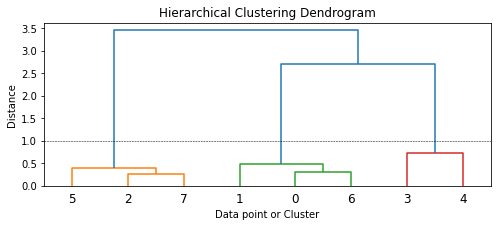

In [20]:
plt.figure(figsize=(8, 3))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data point or Cluster')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=1.0, c='k', ls='--', lw=0.5)

Getting the cluster labels


In [21]:
max_dist = 1.0
cluster_labels = fcluster(Z, max_dist, criterion='distance')
cluster_labels = pd.DataFrame(cluster_labels, columns= ['ClusterLabel'])
corpus_cluster = pd.concat([corpus_df, cluster_labels], axis=1)
corpus_cluster

,Document,Category,ClusterLabel
0,The sky is blue and beautiful.,weather,2
1,Love this blue and beautiful sky!,weather,2
2,The quick brown fox jumps over the lazy dog.,animals,1
3,"A king's breakfast has sausages, ham, bacon, e...",food,3
4,"I love green eggs, ham, sausages and bacon!",food,3
5,The brown fox is quick and the blue dog is lazy!,animals,1
6,The sky is very blue and the sky is very beaut...,weather,2
7,The dog is lazy but the brown fox is quick!,animals,1
